<a href="https://colab.research.google.com/github/kartik727/neural-machine-translation/blob/master/Seq2Seq_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seq2Seq with attention

## Dependencies
Primary library used for modelling and training - trax

## Data - Tensorflow Datasets (TFDS)
1. OPUS (`'opus'`)

In [1]:
import random
import numpy as np
import re
from collections import defaultdict
import os
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import shutil
from tqdm import tqdm, trange

import nltk
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
# Utils

!git clone https://gist.github.com/c47d0ad11b63acd334e760fc4ed21488.git namespace
!git clone https://gist.github.com/553d2d565a17788d6217eba65e770c41.git tb_logger

fatal: destination path 'namespace' already exists and is not an empty directory.
fatal: destination path 'tb_logger' already exists and is not an empty directory.


In [3]:
from namespace.namespace import Namespace
from tb_logger.tensorboard_logger_2 import Logger as TB_Logger

In [4]:
config_dict = {
    'model' : {
        'embedding_size' : 256,
        'n_encoder_layers' : 1,
        'n_decoder_layers' : 1,
        'n_attention_heads' : 1,
        'attention_dropout' : 0.,
        'n_units' : 1024,
        'batch_size' : 32,
        'recurrent_cell' : 'LSTM'
    },
    'languages' : {
        'input' : {
            'name' : 'en',
            'sentence_maxlen' : 30,
            'vocab_size' : 20_000,
        },
        'target' : {
            'name' : 'de',
            'sentence_maxlen' : 30,
            'vocab_size' : 20_000,
        }
    },
    'data' : {
        'dataset_name' : 'opus',
        'load_pcnt' : 20,
        'shuffle' : True
    },
    'preprocessing' : {
        'start_token' : '<start>',
        'end_token' : '<end>',
        'oov_token' : '<unk>',
        'padding' : 'post',
        'tokenizer_fit_pcnt' : 30
    },
    'training' : {
        'epochs' : 1
    },
    'logging' : {
        'dir' : '/content/out/tensorboard/logs/',
        'name' : 'seq2seq machine translation',
        'description' : 'NMT using seq2seq model with attention'
    }
}

config = Namespace(**config_dict)

In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  print('Not connected to a TPU runtime')

Not connected to a TPU runtime


In [7]:
logger = TB_Logger(config.logging.dir)

In [8]:
dataset_train = tfds.load(config.data.dataset_name, split=f'train[:{config.data.load_pcnt}%]', batch_size=-1, shuffle_files=config.data.shuffle)
ds_np = tfds.as_numpy(dataset_train)

In [9]:
class DataGenerator(tf.keras.utils.Sequence):
    link = 'https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly'
    def __init__(self, file_locs, batch_size, shuffle=True):
        self.file_locs = file_locs
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.on_epoch_end()
        
    def on_epoch_end(self):
        '''
        Performs end-of-epoch operations like shuffling data,
        printing info etc.
        '''
        if self.shuffle == True:
            self.metadata = shuffle(self.metadata)
            
    def __generate_data(self, batch_metadata):
        df = pd.DataFrame(columns=['filename', 'X'])
        
        for i, r in batch_metadata.iterrows():
            X_row = extract(self.file_locs[i], sr=self.sr)
            df = df.append({'filename':i, 'X':X_row}, ignore_index=True)
        
        df.set_index('filename', drop=True, inplace=True)
        df_batch = df.join(batch_metadata, how='inner')
        self.df = df
        self.df_batch = df_batch
        
        X_batch = np.stack(np.array(df_batch['X'])) # Workaround. Needs fix
        
        Y_batch_ = np.array(df_batch[self.label])
        Y_batch_ = self.le.transform(Y_batch_)
        Y_batch = Y_batch_ #tf.keras.utils.to_categorical(Y_batch_, num_classes=self.num_classes)
        
        return X_batch, Y_batch
        
    def __len__(self):
        return int(np.floor(self.metadata.shape[0] / self.batch_size))
    
    def __getitem__(self, index):
        batch_metadata = self.metadata.iloc[index*self.batch_size:(index+1)*self.batch_size, :]
        return self.__generate_data(batch_metadata)

In [10]:
def preprocess_sentence(w, max_len):
    w = w.decode().lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    w = ' '.join(w.split()[:max_len])

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = f'{config.preprocessing.start_token} {w} {config.preprocessing.end_token}'
    return w

In [11]:
def preprocess_data(data, max_len):
    res = []
    for sentence in data:
        res.append(preprocess_sentence(sentence, max_len))
    return np.array(res)

In [12]:
lang_tokenizer = {}
preprocessed_dataset = {}

for lang in config.languages:
    print(f'Preprocessing {lang.name}')
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=lang.vocab_size,
        filters='',
        oov_token=config.preprocessing.oov_token
        )
    preprocessed_data = preprocess_data(ds_np[lang.name], lang.sentence_maxlen)
    tokenizer.fit_on_texts(preprocessed_data)
    lang_tokenizer[lang.name] = tokenizer

    tensor = tokenizer.texts_to_sequences(preprocessed_data)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding=config.preprocessing.padding)
    preprocessed_dataset[lang.name] = tensor

Preprocessing en
Preprocessing de


In [13]:
dataset = tf.data.Dataset.from_tensor_slices((
    preprocessed_dataset[config.languages.input.name],
    preprocessed_dataset[config.languages.target.name]
    ))
dataset = dataset.batch(config.model.batch_size, drop_remainder=True)

In [14]:
steps_per_epoch = len(dataset)

vocab_input_size = len(lang_tokenizer[config.languages.input.name].word_index)+1
vocab_target_size = len(lang_tokenizer[config.languages.target.name].word_index)+1

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([32, 32]), TensorShape([32, 32]))

In [16]:
max_len_inp = preprocessed_dataset[config.languages.input.name].shape[1]
max_len_targ = preprocessed_dataset[config.languages.target.name].shape[1]

## Keras

Source: [Tensorflow NMT tutorial](https://www.tensorflow.org/tutorials/text/nmt_with_attention)

In [17]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [18]:
encoder = Encoder(vocab_input_size, config.model.embedding_size, config.model.n_units, config.model.batch_size)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
print('Encoder Hidden state shape: (batch size, units)', sample_hidden.shape)

Encoder output shape: (batch size, sequence length, units) (32, 32, 1024)
Encoder Hidden state shape: (batch size, units) (32, 1024)


In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [20]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units)", attention_result.shape)
print("Attention weights shape: (batch_size, sequence_length, 1)", attention_weights.shape)

Attention result shape: (batch size, units) (32, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (32, 32, 1)


In [21]:
class Decoder(tf.keras.Model):
  def __init__(self, recurrent_cell, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.recurrent_cell = recurrent_cell
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                     return_sequences=True,
                                     return_state=True)
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    if self.recurrent_cell=='GRU':
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
    elif self.recurrent_cell=='LSTM':
        output, state, _ = self.lstm(x)
    else:
        raise Exception('Invalid recurrent cell')

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [22]:
decoder = Decoder(config.model.recurrent_cell, vocab_target_size, config.model.embedding_size, config.model.n_units, config.model.batch_size)

sample_decoder_output, _, _ = decoder(tf.random.uniform((config.model.batch_size, 1)),
                                      sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)

Decoder output shape: (batch_size, vocab size) (32, 43497)


In [23]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [24]:
checkpoint_dir = '/content/out/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [25]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([lang_tokenizer[config.languages.target.name].word_index[config.preprocessing.start_token]] * config.model.batch_size, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [26]:
# Emperical estimate of time on colab for opus

est_time = 0.02667*config.data.load_pcnt*config.training.epochs

print(f'Estimated training time: {est_time:.2f} hrs.')

Estimated training time: 0.53 hrs.


In [27]:
for epoch in range(config.training.epochs):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):       
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        logger.log_scalar('batch_loss', batch_loss, step=batch)

        if batch % 100 == 0:
            print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
    
    logger.log_scalar('total_loss', total_loss, step=epoch)
    # saving (checkpoint) the model every 2 epochs
    # if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 3.9530
Epoch 1 Batch 100 Loss 2.5282
Epoch 1 Batch 200 Loss 2.1872
Epoch 1 Batch 300 Loss 1.8596
Epoch 1 Batch 400 Loss 2.7386
Epoch 1 Batch 500 Loss 2.0951
Epoch 1 Batch 600 Loss 2.4958
Epoch 1 Batch 700 Loss 1.6864
Epoch 1 Batch 800 Loss 2.1364
Epoch 1 Batch 900 Loss 1.8194
Epoch 1 Batch 1000 Loss 0.9551
Epoch 1 Batch 1100 Loss 1.9577
Epoch 1 Batch 1200 Loss 1.5099
Epoch 1 Batch 1300 Loss 1.8507
Epoch 1 Batch 1400 Loss 1.4179
Epoch 1 Batch 1500 Loss 1.4907
Epoch 1 Batch 1600 Loss 1.2693
Epoch 1 Batch 1700 Loss 1.7232
Epoch 1 Batch 1800 Loss 1.3849
Epoch 1 Batch 1900 Loss 1.4567
Epoch 1 Batch 2000 Loss 1.7042
Epoch 1 Batch 2100 Loss 1.4860
Epoch 1 Batch 2200 Loss 1.0506
Epoch 1 Batch 2300 Loss 1.7530
Epoch 1 Batch 2400 Loss 1.3665
Epoch 1 Batch 2500 Loss 1.2023
Epoch 1 Batch 2600 Loss 1.4430
Epoch 1 Batch 2700 Loss 1.3134
Epoch 1 Batch 2800 Loss 1.1136
Epoch 1 Batch 2900 Loss 0.8987
Epoch 1 Batch 3000 Loss 1.2144
Epoch 1 Batch 3100 Loss 0.7904
Epoch 1 Batch 3200 L

In [28]:
def evaluate(sentence):
    attention_plot = np.zeros((max_len_targ, max_len_inp))

    sentence = preprocess_sentence(sentence, config.languages.input.sentence_maxlen)
    oov_index = lang_tokenizer[config.languages.input.name].word_index[config.preprocessing.oov_token]
    inputs = [lang_tokenizer[config.languages.input.name].word_index.get(i, oov_index) for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                            maxlen=max_len_inp,
                                                            padding=config.preprocessing.padding)
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, config.model.n_units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([lang_tokenizer[config.languages.target.name].word_index[config.preprocessing.start_token]], 0)

    for t in range(max_len_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                            dec_hidden,
                                                            enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() # Greedy

        result += lang_tokenizer[config.languages.target.name].index_word[predicted_id] + ' '

        if lang_tokenizer[config.languages.target.name].index_word[predicted_id] == config.preprocessing.end_token:
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [29]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='gray')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [30]:
def translate(sentence):
    if type(sentence)==str:
        sentence = sentence.encode()
    result, sentence, attention_plot = evaluate(sentence)

    print('Input:', sentence)
    print('Predicted translation:', result)

    attention_plot = attention_plot[:len(result.split(' ')),
                                    :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> there are no known side effects <end>
Predicted translation: es gibt keine bekannt <end> 


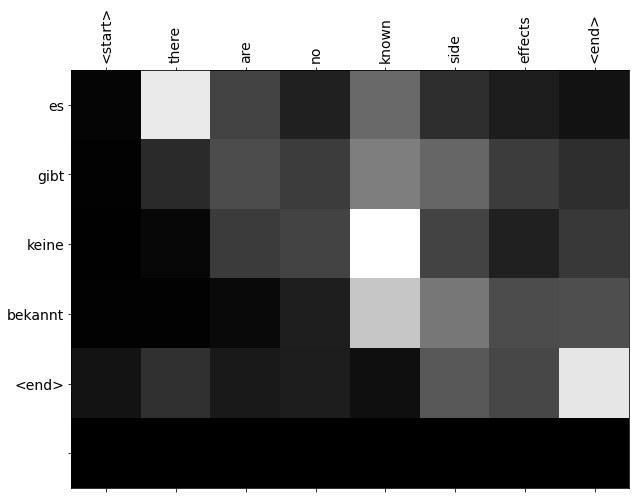

In [43]:
translate('There are no known side effects')

In [32]:
!tensorboard dev upload --logdir {config.logging.dir} \
  --name "{config.logging.name}" \
  --description "{config.logging.description}" \
  --one_shot

2021-05-21 18:53:18.210675: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/out/tensorboard/logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Aw

In [33]:
config.logging.dir

'/content/out/tensorboard/logs/'

In [37]:
data_src_1 = '/content/out/training_checkpoints/ckpt-1.data-00000-of-00001'
data_dest_1 = '/content/drive/MyDrive/Colab Notebooks/Data/seq2seqcheckpoints/ckpt-1.data-00000-of-00001'

data_src_2 = '/content/out/training_checkpoints/ckpt-1.index'
data_dest_2 = '/content/drive/MyDrive/Colab Notebooks/Data/seq2seqcheckpoints/ckpt-1.index'

In [38]:
d = shutil.copyfile(data_src_2, data_dest_2)